# Cell assembly analyses

In [1]:
%cd ..

D:\ryanh\github\cell_assembly_replay


In [2]:
import itertools
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from cell_assembly_replay import assembly,assembly_run,functions
import pandas as pd
import nelpy as nel
import nelpy.io
import nelpy.plotting as npl
import multiprocessing
from joblib import Parallel, delayed
import pickle
import glob
from scipy.signal import find_peaks

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## load example data

In [3]:
# output files are saved here
save_path = 'F:/Projects/PAE_PlaceCell/analysis/cell_assembly/'
# where base data will be read in from
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
# where spike times will be read in
spike_path = 'F:/Projects/PAE_PlaceCell/analysis/spikes/'
# data frame contain info for each unit
df_cell_class = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/cell_recruitment/processed/pyr_int_df.csv')
# data frame contain info for each ripple
swr_df = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/swr_data/post_processed/swr_df.csv')
# data frame contain info for each mua evebt
mua_df = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/multiunit_data/post_processed/mua_df.csv')
# data frame with ever cell in data set
cell_list = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\cell_list.csv')


## run all sessions

runs through every session in data frame and saves results for each session in a .pkl file to the save path


    results['patterns']
    results['significance']
    results['zactmat']
    results['assemblyAct']
    results['session']
    results['session_ripple']
    results['area']
    results['area_ripple']
    results['assembl_strength']
    results['assembl_frac']
    results['n_assembl']
    results['n_units']
    results['n_assembl_n_cell_frac']
    results['n_cells_per_assembl']

In [ ]:
%%time

assembly_run.assembly_run(spike_path,save_path,swr_df,cell_list,parallel=False)

## pull in data for comparison

In [4]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + '*.pkl')
    
    session_ = []
    assembl_strength = []
    assembl_frac = []
    n_assembl = []
    n_units = []
    n_assembl_n_cell_frac = []
    n_cells_per_assembl = []

    session_ripple = []
    area = []
    area_ripple = []
    
    for session in sessions:
            with open(session, 'rb') as f:
                results = pickle.load(f)

            session_.append(results['session'])
            session_ripple.append(results['session_ripple'])
            area.append(results['area'])
            area_ripple.append(results['area_ripple'])
            assembl_strength.append(results['assembl_strength'])
            assembl_frac.append(results['assembl_frac'])
            n_assembl.append(results['n_assembl'])
            n_units.append(results['n_units'])
            n_assembl_n_cell_frac.append(results['n_assembl_n_cell_frac'])
            n_cells_per_assembl.append(results['n_cells_per_assembl'])
       
    results = {
        "session": list(itertools.chain(*session_)),
        "session_ripple": list(itertools.chain(*session_ripple)),
        "area": list(itertools.chain(*area)),
        "area_ripple": list(itertools.chain(*area_ripple)),
        "assembl_strength": list(itertools.chain(*assembl_strength)),
        "assembl_frac": list(itertools.chain(*assembl_frac)),
        "n_assembl": list(itertools.chain(*n_assembl)),
        "n_units": list(itertools.chain(*n_units)),
        "n_assembl_n_cell_frac": list(itertools.chain(*n_assembl_n_cell_frac)),
        "n_cells_per_assembl": list(itertools.chain(*n_cells_per_assembl))
        }     
    return results

results = load_in_everything(save_path)
results.keys()

dict_keys(['session', 'session_ripple', 'area', 'area_ripple', 'assembl_strength', 'assembl_frac', 'n_assembl', 'n_units', 'n_assembl_n_cell_frac', 'n_cells_per_assembl'])

In [5]:
for item in results.keys():
    print(item,len(results[item]))

session 221
session_ripple 20180
area 221
area_ripple 20180
assembl_strength 20180
assembl_frac 20180
n_assembl 221
n_units 221
n_assembl_n_cell_frac 221
n_cells_per_assembl 221


## make data frames

In [6]:
def add_group_affiliation(df):
    control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
    pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

    df['group'] = np.ones_like(df.session)

    regstr = '|'.join(control)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.group[idx] = 'control'

    regstr = '|'.join(pae)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.group[idx] = 'pae'
    return df

df = pd.DataFrame()

df['session'] = results['session'] 
# add rat ID
rat = [s.split('_')[0] for s in df.session]
df['rat']=rat
# add group affiliation to df
df = add_group_affiliation(df)    

df['area'] = results['area'] 
df['n_assembl'] = results['n_assembl']
df['n_units'] = results['n_units']
df['n_assembl_n_cell_frac'] = results['n_assembl_n_cell_frac']
df['n_cells_per_assembl'] = results['n_cells_per_assembl']

df.to_csv('F:/Projects/PAE_PlaceCell/analysis/cell_assembly/post_processed/cell_assembly.csv')

df

,session,rat,group,area,n_assembl,n_units,n_assembl_n_cell_frac,n_cells_per_assembl
0,LEM3116_S20180715121821,LEM3116,control,ca1,5.0,25.0,0.200000,1.333333
1,LEM3116_S20180715160836,LEM3116,control,ca1,2.0,6.0,0.333333,NaN
2,LEM3116_S20180716115155,LEM3116,control,ca1,2.0,8.0,0.250000,NaN
3,LEM3116_S20180716174306,LEM3116,control,ca1,8.0,36.0,0.222222,1.666667
4,LEM3116_S20180717110938,LEM3116,control,ca1,25.0,108.0,0.231481,3.461538
...,...,...,...,...,...,...,...,...
216,RH16_S20161021165052,RH16,pae,ca1,2.0,7.0,0.285714,NaN
217,RH16_S20161030145324,RH16,pae,ca1,3.0,12.0,0.250000,1.500000
218,RH16_S20161126145021,RH16,pae,ca1,4.0,18.0,0.222222,1.500000
219,RH16_S20161126150318,RH16,pae,ca1,3.0,22.0,0.136364,NaN


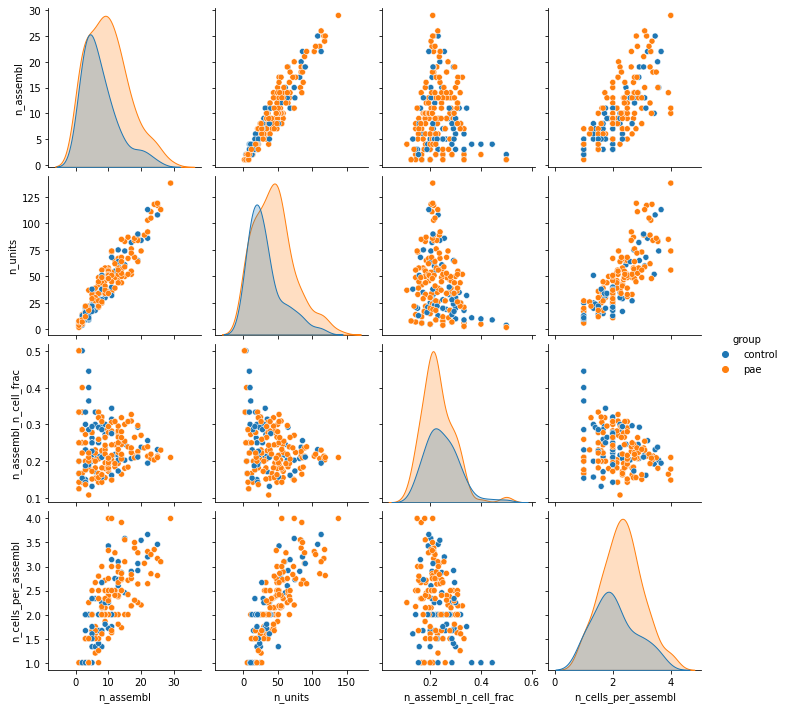

In [7]:
sns.pairplot(df,hue="group")

## add features to ripple data frame

There is a session with a single ripple that caused an odd issue when I created my lists so I need to flatten them before adding them to the df

In [7]:
def manually_flatten_list_of_strings(my_list):
    strings = []
    for val in my_list:
        if not isinstance(val, str):
            strings.append(val[0])
        else:
            strings.append(val) 
    return strings    

def manually_flatten_list_of_floats(my_list):
    out = []
    for val in my_list:
        if not isinstance(val, float):
            out.append(val[0])
        else:
            out.append(val) 
    return out 

df2 = pd.DataFrame()

df2['session'] = manually_flatten_list_of_strings(results['session_ripple'])
# add rat ID
rat = [s.split('_')[0] for s in df2.session]
df2['rat'] = rat
# add group affiliation to df
df2 = add_group_affiliation(df2)   

df2['area'] = manually_flatten_list_of_strings(results['area_ripple'])


df2['assembl_strength'] = manually_flatten_list_of_floats(results['assembl_strength'])
df2['assembl_frac'] = manually_flatten_list_of_floats(results['assembl_frac'])

# and drop rows with nan
df2 = df2.dropna()

n_assembl = [df.n_assembl[df.session == sess].iloc[0] for sess in df2.session]
df2['n_assembl'] = n_assembl

df2.to_csv('F:/Projects/PAE_PlaceCell/analysis/cell_assembly/post_processed/cell_assembly_per_event.csv')


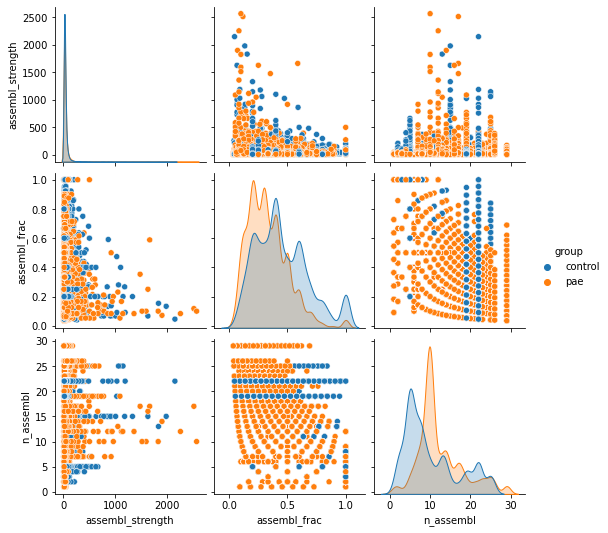

In [9]:
sns.pairplot(df2,hue="group")

In [8]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'

In [9]:
fig_save_path = 'D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/replay_section/'

## make comparison plots for assembly strength

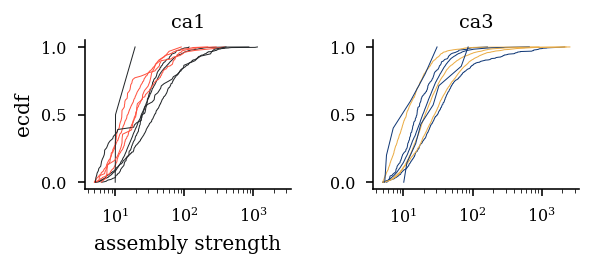

In [29]:
group_colors = {"controlca1": '#222629ff',
                "controlca3": '#103876ff',
                'paeca1': '#ff5240ff',
                'paeca3': '#ebad46ff'} 
def ecdf(x):
    xs = np.sort(x)
    ys = np.linspace(0,1,len(xs))
    return xs, ys


def plot_ecdf(var,df,area,ax,group_colors):
    for rat in pd.unique(df.rat):
        y = df[(df.rat == rat) & (df.area == area)]
        if y.empty == False:
            xs, ys = ecdf(y[var])
            ax.plot(xs,ys,color=group_colors[y.group.iloc[0]+y.area.iloc[0]],linewidth=.5)

            
fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=.75, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.4)
axs = axs.ravel()

plot_ecdf('assembl_strength',df2,'ca1',axs[0],group_colors)
axs[0].set_xlabel('assembly strength')
axs[0].set_ylabel('ecdf')
axs[0].set_title('ca1')

plot_ecdf('assembl_strength',df2,'ca3',axs[1],group_colors)
axs[1].set_title('ca3')

axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[0].set_xlim(min(axs[0].get_xlim()[0],axs[1].get_xlim()[0]),max(axs[0].get_xlim()[1],axs[1].get_xlim()[1]))
axs[1].set_xlim(min(axs[0].get_xlim()[0],axs[1].get_xlim()[0]),max(axs[0].get_xlim()[1],axs[1].get_xlim()[1]))
 
for i in range(2):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    
plt.savefig(os.path.join(fig_save_path,'assembl_strength.svg'),dpi=300,bbox_inches='tight')

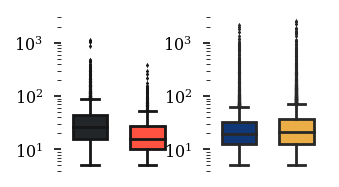

In [267]:
fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=.4, subplots=(1, 1)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.3)
axs = axs.ravel()

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="assembl_strength", data=df2[(df2.area=='ca1')],
            width=.6,ax=axs[0],saturation=1,fliersize=.5)
axs[0].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)


sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="assembl_strength", data=df2[(df2.area=='ca3')],
            width=.6,ax=axs[1],saturation=1,fliersize=.5)
axs[1].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

axs[0].set_yscale("log")
axs[1].set_yscale("log")

axs[0].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
axs[1].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
 
sns.despine(trim=True, left=True, bottom=True)
plt.savefig(os.path.join(fig_save_path,'assembl_strength_box.svg'),dpi=300,bbox_inches='tight')


## make comparion plots for assembl_frac

    or the proportion of active (R>5) assemblies during each ripple

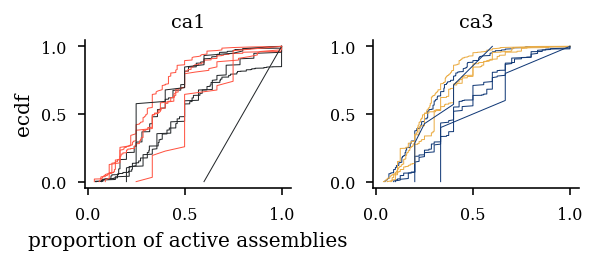

In [268]:
fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=.75, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.4)
axs = axs.ravel()

plot_ecdf('assembl_frac',df2,'ca1',axs[0],group_colors)
axs[0].set_xlabel('proportion of active assemblies')
axs[0].set_ylabel('ecdf')
axs[0].set_title('ca1')

plot_ecdf('assembl_frac',df2,'ca3',axs[1],group_colors)
axs[1].set_title('ca3')

# axs[0].set_xscale('log')
# axs[1].set_xscale('log')

axs[0].set_xlim(min(axs[0].get_xlim()[0],axs[1].get_xlim()[0]),max(axs[0].get_xlim()[1],axs[1].get_xlim()[1]))
axs[1].set_xlim(min(axs[0].get_xlim()[0],axs[1].get_xlim()[0]),max(axs[0].get_xlim()[1],axs[1].get_xlim()[1]))
 
for i in range(2):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    
plt.savefig(os.path.join(fig_save_path,'assembl_frac.svg'),dpi=300,bbox_inches='tight')    

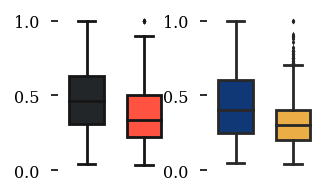

In [269]:
fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=.4, subplots=(1, 1)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.3)
axs = axs.ravel()

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="assembl_frac", data=df2[(df2.area=='ca1')],
            width=.6,ax=axs[0],saturation=1,fliersize=.5)
axs[0].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)


sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="assembl_frac", data=df2[(df2.area=='ca3')],
            width=.6,ax=axs[1],saturation=1,fliersize=.5)
axs[1].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

# axs[0].set_yscale("log")
# axs[1].set_yscale("log")

axs[0].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
axs[1].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
 
sns.despine(trim=True, left=True, bottom=True)

plt.savefig(os.path.join(fig_save_path,'assembl_frac_box.svg'),dpi=300,bbox_inches='tight')


# get within ripple stats for each assembly

    -rate: number of assembly peaks over time during ripple epochs
    -strength: median height of assembly peaks over ripple epochs
    -peaks_per_assembly: number of ripples each assembly had at least 1 peak in

In [10]:
import warnings


In [11]:
%%time
warnings.filterwarnings('ignore')

def get_within_ripple_stats(swr_df,session,assembly_act):
    # create ripple epoch object
    ripple_epoch = nel.EpochArray([np.array([swr_df[swr_df.session == session].start_time,swr_df[swr_df.session == session].end_time]).T])
    # restrict assemblies to ripple epochs
    assembly_act_ripple = assembly_act[ripple_epoch]
    # loop through each assembly and collect rates using n instances where the strength was above 5
    rate = []
    strength = []
    for i in range(assembly_act_ripple.n_signals):
        peaks, _ = find_peaks(assembly_act_ripple.data[i,:],height=5)
        strength.append(np.nanmedian(assembly_act_ripple.data[i,peaks]))
        rate.append(len(peaks) / sum(ripple_epoch.lengths))
        
    peak_map = np.zeros([assembly_act_ripple.n_intervals,assembly_act_ripple[0].n_signals])
    for i in range(assembly_act_ripple.n_intervals):
        for j in range(assembly_act_ripple[i].n_signals):
            peaks, _ = find_peaks(assembly_act_ripple[i].data[j,:],height=5)
            peak_map[i,j] = any(peaks)*1

    peaks_per_assembly = peak_map.sum(axis=0) / assembly_act_ripple.n_intervals
    peaks_per_ripple = peak_map.sum(axis=1) / assembly_act_ripple[0].n_signals
    
    return rate,strength,peaks_per_assembly,peaks_per_ripple

rate = []
strength = []
session_id = []
peaks_per_assembly = []
area = []
for session in pd.unique(swr_df.session):
    with open(os.path.join(save_path,session+'.pkl'), 'rb') as f:
        results = pickle.load(f)
            
    # load spikes & add to object
    spikes = np.load(os.path.join(spike_path,session)+'.npy', allow_pickle=True)
    spikes_ = list(itertools.chain(*spikes))
    session_bounds = nel.EpochArray([min(spikes_), max(spikes_)])
    
    for i in range(len(results['area'])):
        
        # check if assemblies exist
        if len(results['assemblyAct'][i])==0:
            rate.append(np.nan)
            strength.append(np.nan)
            peaks_per_assembly.append(np.nan)
            session_id.append(session)
            area.append(results['area'][i])
            continue
            
        # pack assemblies into nelpy object
        assemblyAct = np.vstack(results['assemblyAct'][i])

        ts = np.linspace(session_bounds.data[0][0],session_bounds.data[0][1],assemblyAct.shape[1])
        assembly_act = nel.AnalogSignalArray(assemblyAct,timestamps=ts,fs=1000)

        # get rates per assembly
        rate_, strength_, peaks_per_assembly_, _ = get_within_ripple_stats(swr_df,session,assembly_act)
        rate.append(rate_)
        strength.append(strength_)
        peaks_per_assembly.append(peaks_per_assembly_)

        # make vector of session names       
        session_id.append(np.full(assembly_act.n_signals, session))
        
        area.append(np.full(assembly_act.n_signals, results['area'][i]))

df = pd.DataFrame()
df['session'] = np.hstack(session_id)
rat = [s.split('_')[0] for s in df.session]
df['rat'] = rat
df = add_group_affiliation(df)   
df['area'] = np.hstack(area)
df['within_ripple_rate'] = np.hstack(rate)
df['assembly_strength'] = np.hstack(strength)
df['peaks_per_assembly'] = np.hstack(peaks_per_assembly)

# add n ripples
n_ripples = []
for sess in df.session:
    n_ripples.append(sum(swr_df.session == sess)) 
df['n_ripples'] = n_ripples   

df.to_csv('F:/Projects/PAE_PlaceCell/analysis/cell_assembly/post_processed/within_ripple_rate.csv')

Wall time: 17min 4s


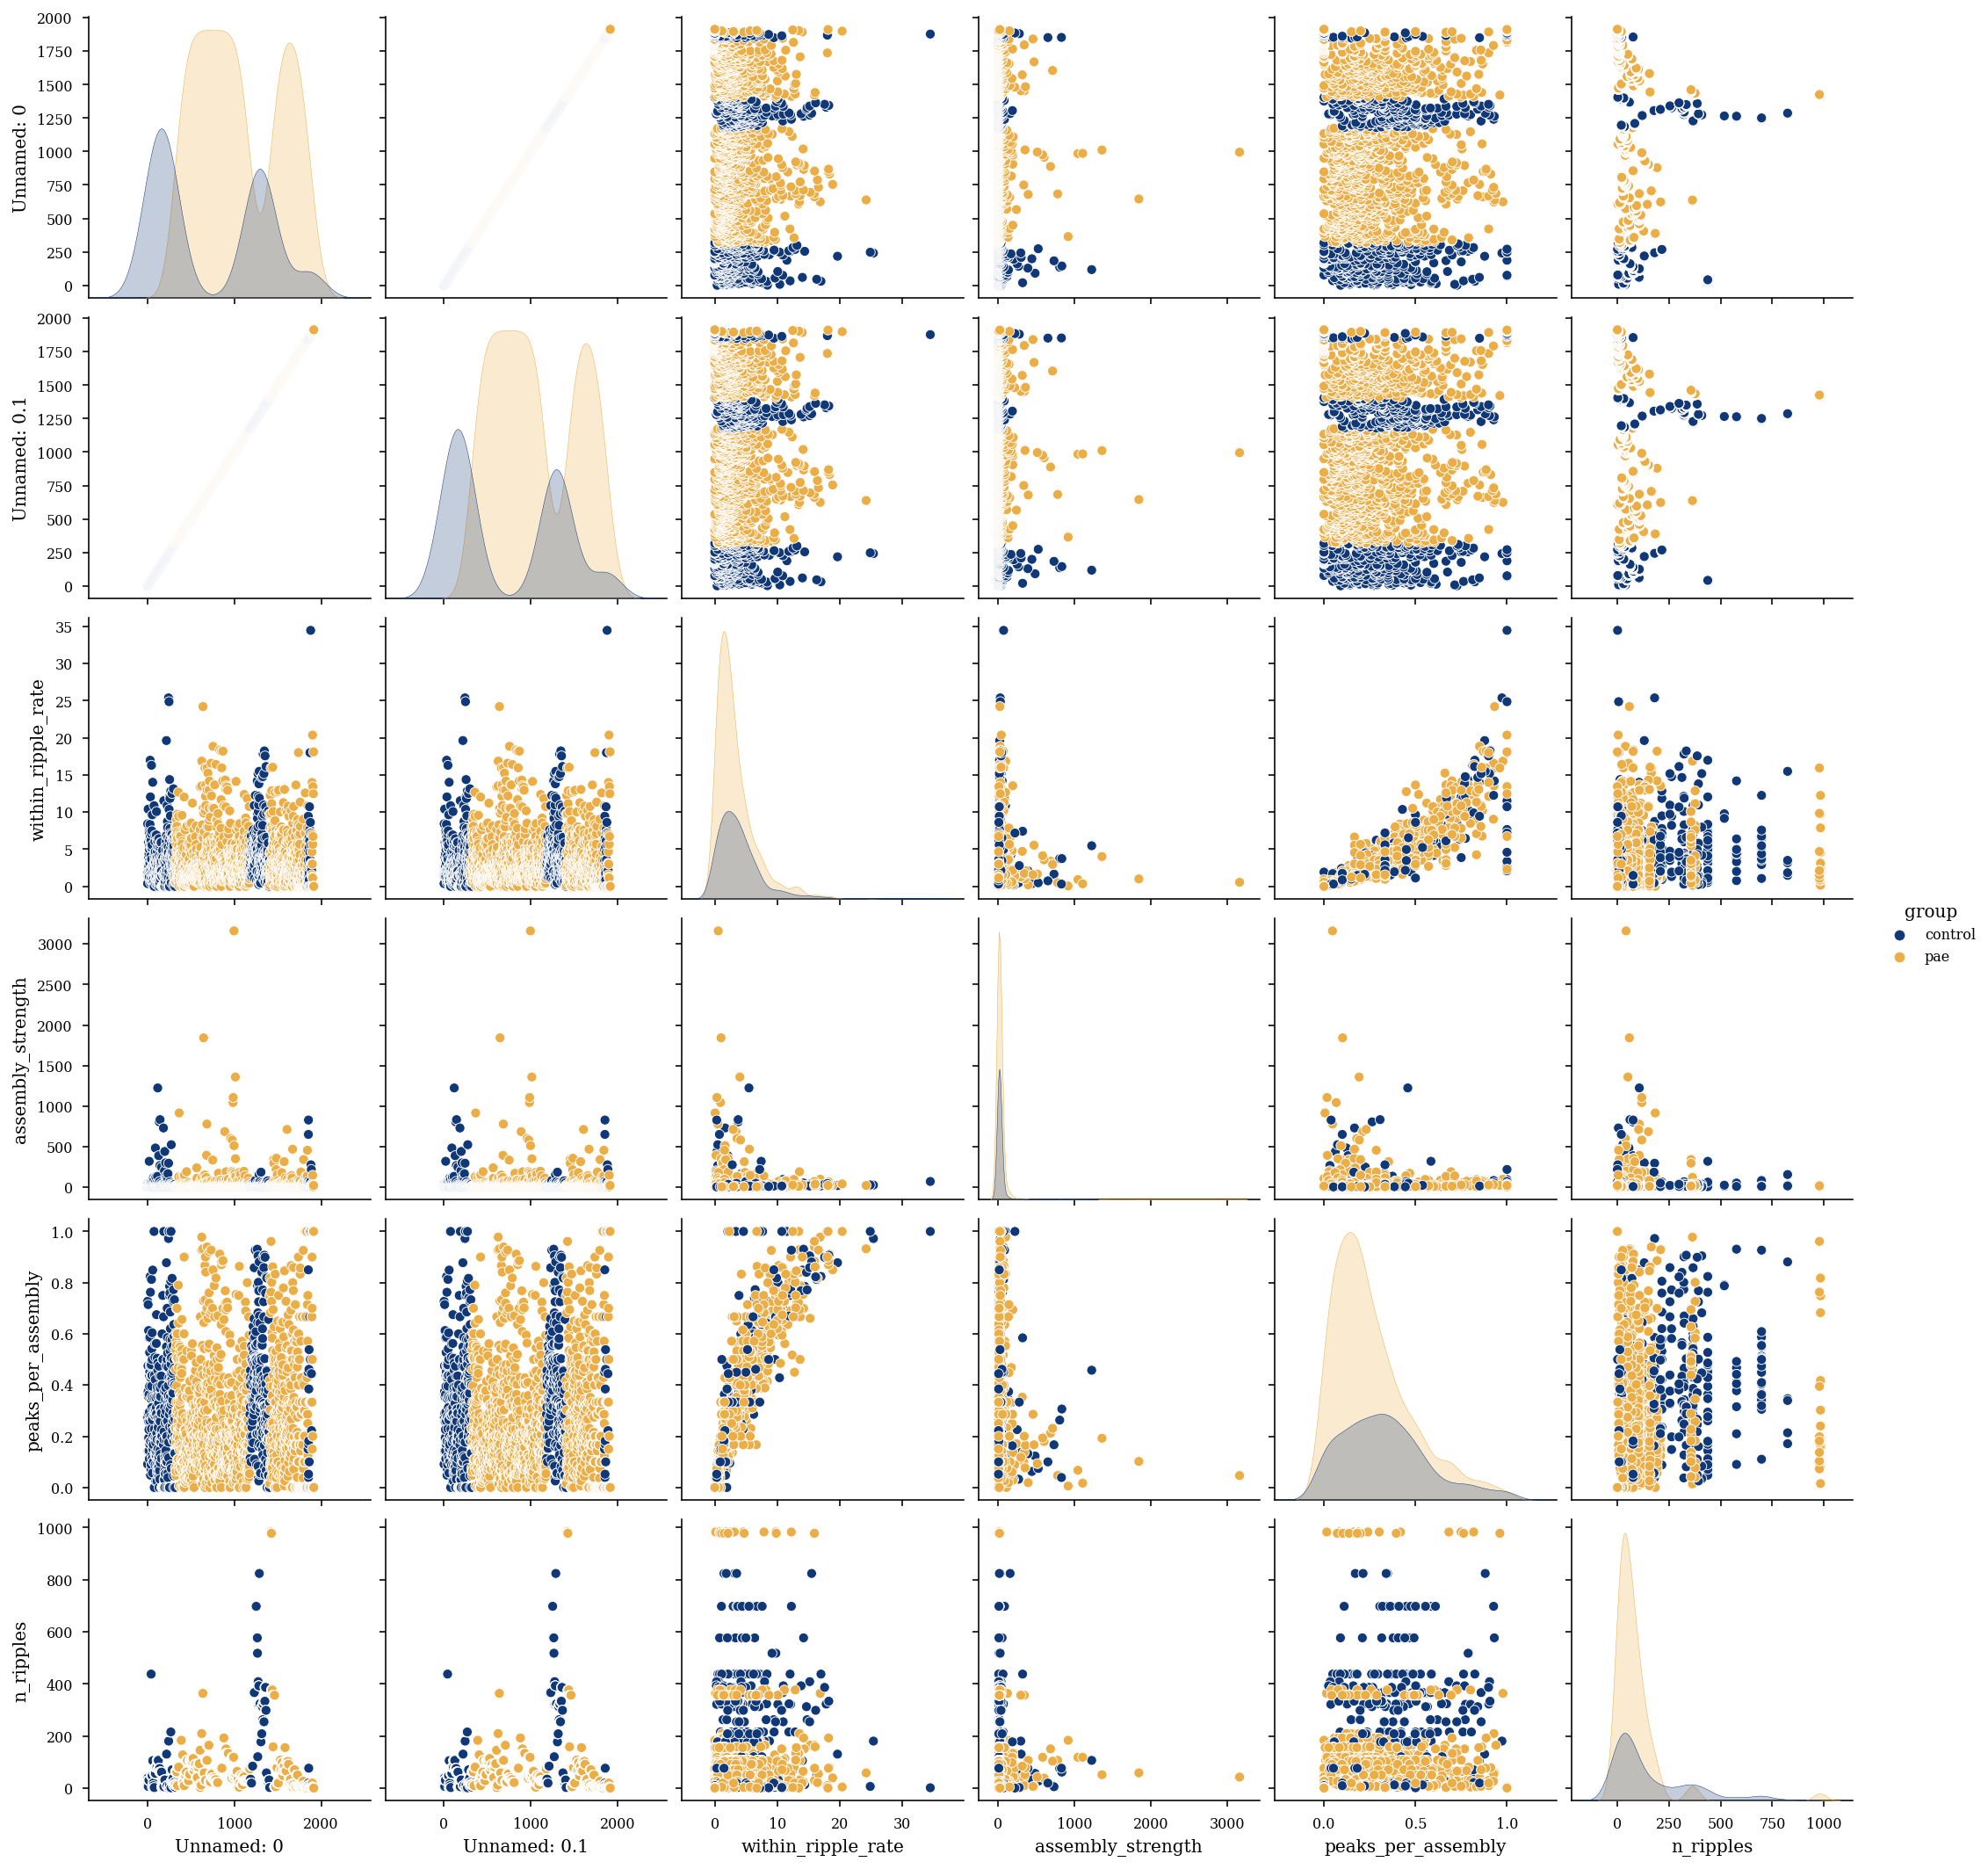

In [39]:
df = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/cell_assembly/post_processed/within_ripple_rate.csv')

sns.pairplot(df,hue="group")

In [40]:
df = df[df.n_ripples >= 25]

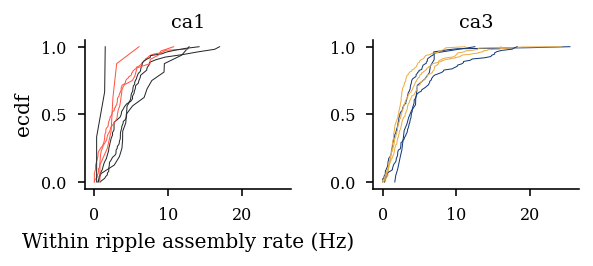

In [41]:
fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=.75, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.4)
axs = axs.ravel()

plot_ecdf('within_ripple_rate',df,'ca1',axs[0],group_colors)
axs[0].set_xlabel('Within ripple assembly rate (Hz)')
axs[0].set_ylabel('ecdf')
axs[0].set_title('ca1')

plot_ecdf('within_ripple_rate',df,'ca3',axs[1],group_colors)
axs[1].set_title('ca3')

# axs[0].set_xscale('log')
# axs[1].set_xscale('log')

axs[0].set_xlim(min(axs[0].get_xlim()[0],axs[1].get_xlim()[0]),max(axs[0].get_xlim()[1],axs[1].get_xlim()[1]))
axs[1].set_xlim(min(axs[0].get_xlim()[0],axs[1].get_xlim()[0]),max(axs[0].get_xlim()[1],axs[1].get_xlim()[1]))
 
for i in range(2):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    
plt.savefig(os.path.join(fig_save_path,'within_ripple_rate.svg'),dpi=300,bbox_inches='tight')   

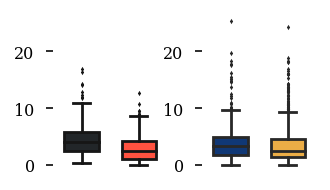

In [42]:
fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=.4, subplots=(1, 1)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.3)
axs = axs.ravel()

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="within_ripple_rate", data=df[(df.area=='ca1')],
            width=.6,ax=axs[0],saturation=1,fliersize=.5)
axs[0].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)


sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="within_ripple_rate", data=df[(df.area=='ca3')],
            width=.6,ax=axs[1],saturation=1,fliersize=.5)
axs[1].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

# axs[0].set_yscale("log")
# axs[1].set_yscale("log")

axs[0].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
axs[1].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
 
sns.despine(trim=True, left=True, bottom=True)

plt.savefig(os.path.join(fig_save_path,'within_ripple_rate_box.svg'),dpi=300,bbox_inches='tight')


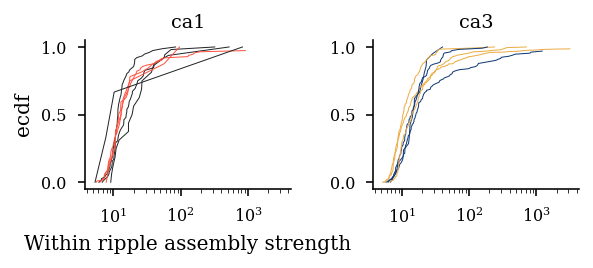

In [43]:
fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=.75, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.4)
axs = axs.ravel()

plot_ecdf('assembly_strength',df,'ca1',axs[0],group_colors)
axs[0].set_xlabel('Within ripple assembly strength')
axs[0].set_ylabel('ecdf')
axs[0].set_title('ca1')

plot_ecdf('assembly_strength',df,'ca3',axs[1],group_colors)
axs[1].set_title('ca3')

axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[0].set_xlim(min(axs[0].get_xlim()[0],axs[1].get_xlim()[0]),max(axs[0].get_xlim()[1],axs[1].get_xlim()[1]))
axs[1].set_xlim(min(axs[0].get_xlim()[0],axs[1].get_xlim()[0]),max(axs[0].get_xlim()[1],axs[1].get_xlim()[1]))
 
for i in range(2):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    
plt.savefig(os.path.join(fig_save_path,'assembly_strength.svg'),dpi=300,bbox_inches='tight')  

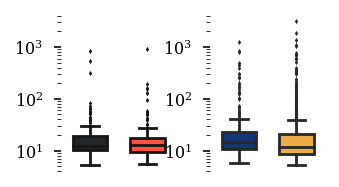

In [44]:
fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=.4, subplots=(1, 1)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.3)
axs = axs.ravel()

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="assembly_strength", data=df[(df.area=='ca1')],
            width=.6,ax=axs[0],saturation=1,fliersize=.5)
axs[0].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)


sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="assembly_strength", data=df[(df.area=='ca3')],
            width=.6,ax=axs[1],saturation=1,fliersize=.5)
axs[1].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

axs[0].set_yscale("log")
axs[1].set_yscale("log")

axs[0].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
axs[1].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
 
sns.despine(trim=True, left=True, bottom=True)

plt.savefig(os.path.join(fig_save_path,'assembly_strength_box.svg'),dpi=300,bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(2,1, figsize=functions.set_size('thesis', fraction=.33, subplots=(2, 1)), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0)
axs = axs.ravel()

plot_ecdf('peaks_per_assembly',df,'ca1',axs[0],group_colors)
axs[0].set_title('ca1')
axs[0].set_ylabel('ecdf')
axs[0].axes.get_xaxis().set_ticks([])


plot_ecdf('peaks_per_assembly',df,'ca3',axs[1],group_colors)
axs[1].set_xlabel('Active assembly proportion')
axs[1].set_ylabel('ecdf')
axs[1].set_title('ca3')

# axs[0].set_xscale('log')
# axs[1].set_xscale('log')

axs[0].set_xlim(min(axs[0].get_xlim()[0],axs[1].get_xlim()[0]),max(axs[0].get_xlim()[1],axs[1].get_xlim()[1]))
axs[1].set_xlim(min(axs[0].get_xlim()[0],axs[1].get_xlim()[0]),max(axs[0].get_xlim()[1],axs[1].get_xlim()[1]))

for i in range(2):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)

plt.savefig(os.path.join(fig_save_path,'peaks_per_assembly.svg'),dpi=300,bbox_inches='tight')  

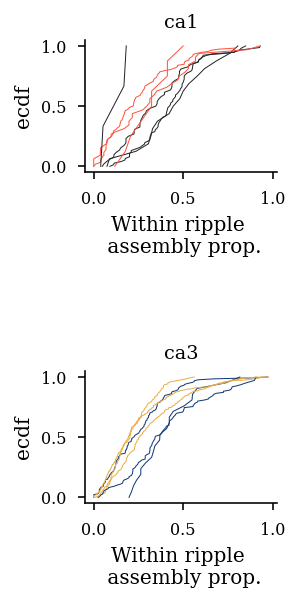

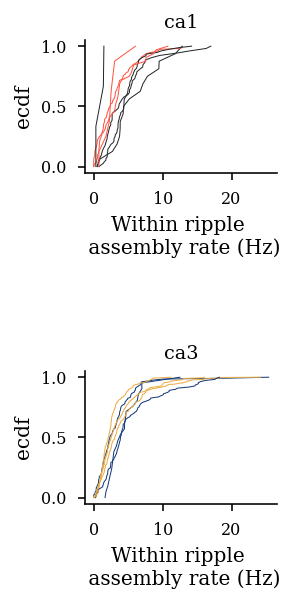

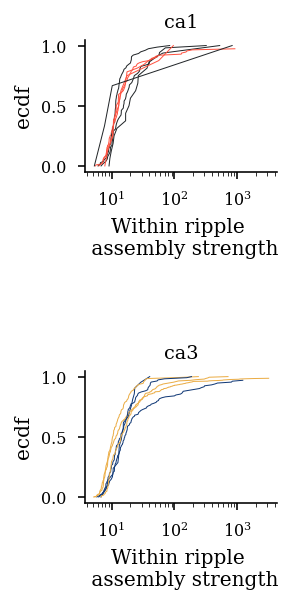

In [86]:
def plot_assembly_stats(df,group_colors,var,xlabel,log=False):
    fig, axs = plt.subplots(2,1, figsize=functions.set_size('thesis', fraction=.292, subplots=(4, 1)), edgecolor='k')
    fig.subplots_adjust(hspace = 1.5, wspace=0)
    axs = axs.ravel()

    plot_ecdf(var,df,'ca1',axs[0],group_colors)
    axs[0].set_title('ca1')
    axs[0].set_ylabel('ecdf')
    axs[0].set_xlabel(xlabel)


    plot_ecdf(var,df,'ca3',axs[1],group_colors)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel('ecdf')
    axs[1].set_title('ca3')
    
    if log:
        axs[0].set_xscale('log')
        axs[1].set_xscale('log')
        
#     axs[0].axes.get_xaxis().set_ticks([])

    axs[0].set_xlim(min(axs[0].get_xlim()[0],axs[1].get_xlim()[0]),max(axs[0].get_xlim()[1],axs[1].get_xlim()[1]))
    axs[1].set_xlim(min(axs[0].get_xlim()[0],axs[1].get_xlim()[0]),max(axs[0].get_xlim()[1],axs[1].get_xlim()[1]))

    for i in range(2):
        right_side = axs[i].spines["right"]
        right_side.set_visible(False)
        top_side = axs[i].spines["top"]
        top_side.set_visible(False)

    plt.savefig(os.path.join(fig_save_path,var+'.svg'),dpi=300,bbox_inches='tight')  

plot_assembly_stats(df,group_colors,'peaks_per_assembly','Within ripple \n assembly prop.')    
plot_assembly_stats(df,group_colors,'within_ripple_rate','Within ripple \n assembly rate (Hz)')        
plot_assembly_stats(df,group_colors,'assembly_strength','Within ripple \n assembly strength',log=True)        


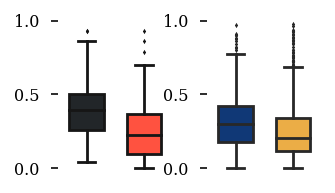

In [46]:
fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=.4, subplots=(1, 1)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.3)
axs = axs.ravel()

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="peaks_per_assembly", data=df[(df.area=='ca1')],
            width=.6,ax=axs[0],saturation=1,fliersize=.5)
axs[0].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)


sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="peaks_per_assembly", data=df[(df.area=='ca3')],
            width=.6,ax=axs[1],saturation=1,fliersize=.5)
axs[1].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

# axs[0].set_yscale("log")
# axs[1].set_yscale("log")

axs[0].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
axs[1].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
 
sns.despine(trim=True, left=True, bottom=True)

plt.savefig(os.path.join(fig_save_path,'peaks_per_assembly_box.svg'),dpi=300,bbox_inches='tight')


## plot example

In [383]:
import matplotlib

def plot_assembl_strength(st,patterns,assembly_act,interval,axs,show_not_in_assmbl=True,vertstack=True):
    

    cmap = matplotlib.cm.get_cmap('tab20b',patterns.shape[0])

    interval = nel.EpochArray(interval)
    st = st[interval]

    assembly_act = assembly_act[interval]
    
    thres = patterns.mean(axis=1) + patterns.std(axis=1)
    temp_pattens = patterns.copy()
    temp_pattens[patterns <  thres[:,np.newaxis]] = 0
    assmbl_unit_id = temp_pattens.argmax(axis=0)
    
    color_idx = 0
    for i,unit_id in enumerate(pd.unique(assmbl_unit_id)):
        npl.rasterplot(st[:,np.where(assmbl_unit_id == unit_id)[0]+1],color=cmap(color_idx), lw=1, lh=2, ax=axs[1], vertstack=vertstack)
        axs[2].plot(assembly_act.abscissa_vals,assembly_act.data[unit_id,:]+10*i, color=cmap(color_idx),linewidth=.75,zorder=1000-i,alpha=1)

        color_idx+=1
        
    npl.rasterplot(st[:,np.where(temp_pattens.max(axis=0) == 0)[0]+1],color='grey', lw=1, lh=2, ax=axs[1], vertstack=True)

    axs[1].set_xlim(interval.data[0][0],interval.data[0][1])
    axs[2].set_xlim(interval.data[0][0],interval.data[0][1])
    

    axs[1].axis('off')
    
    axs[2].spines["right"].set_visible(False)
    axs[2].spines["top"].set_visible(False)
    

In [356]:
# session = 'LEM3124_S20190302163218'
# session = pd.unique(swr_df.session)[4]
# session = 'LEM3206_S20190719140644'
session = 'LEM3206_S20190718143924'

# results = assembly_run.run_all(session,spike_path,save_path,swr_df,cell_list)
# results = assembly_run.run_all(session,spike_path,swr_df,cell_list) 
with open(os.path.join(save_path,session+'.pkl'), 'rb') as f:
            results = pickle.load(f)
# load spikes & add to object
spikes = np.load(os.path.join(spike_path,session)+'.npy', allow_pickle=True)
spikes_ = list(itertools.chain(*spikes))
session_bounds = nel.EpochArray([min(spikes_), max(spikes_)])
st = nel.SpikeTrainArray(timestamps=spikes, support=session_bounds, fs=32000)

# dt = 0.025
# binned_st = st.bin(ds=dt)

assemblyAct = np.vstack(results['assemblyAct'])
# assembly_act = nel.AnalogSignalArray(assemblyAct, timestamps=binned_st.bin_centers,fs=1/dt)
ts = np.linspace(session_bounds.data[0][0],session_bounds.data[0][1],assemblyAct.shape[1])
assembly_act = nel.AnalogSignalArray(assemblyAct,timestamps=ts,fs=1000)

patterns = np.vstack(results['patterns'])


D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!


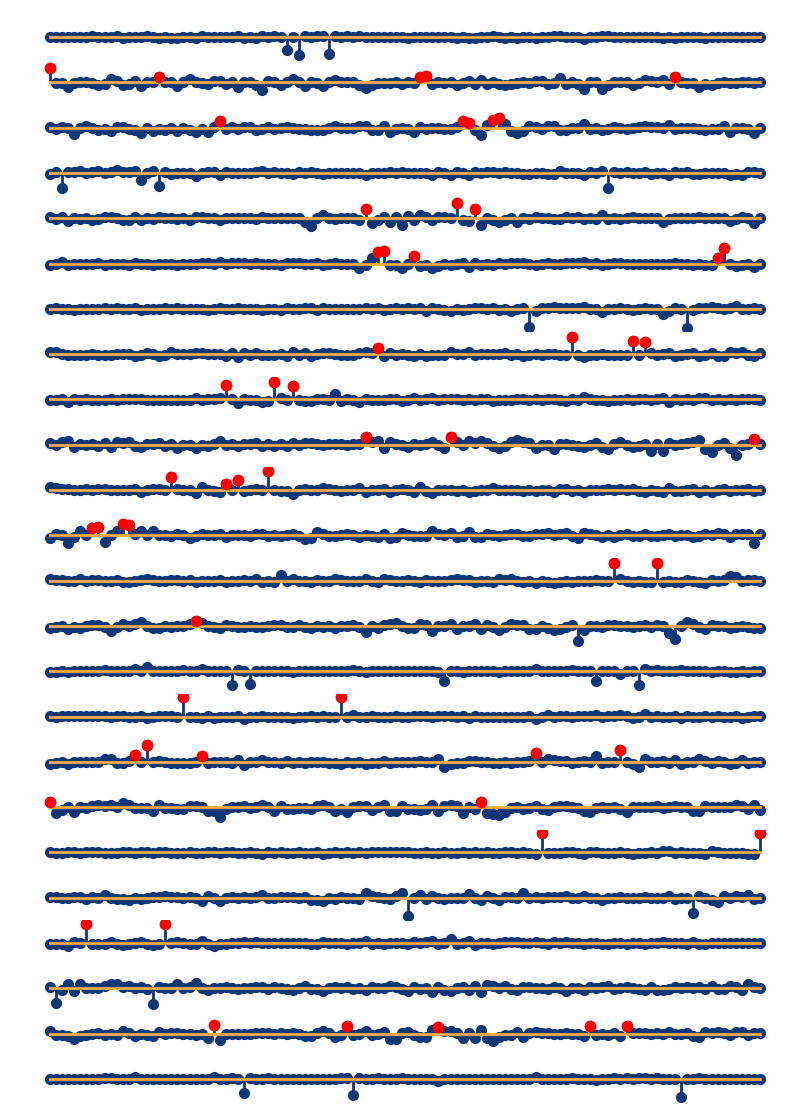

In [357]:
fig, axs = plt.subplots(patterns.shape[0],1, figsize=(7, 10), edgecolor='k')
fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()


for i,assmbl in enumerate(patterns):
    axs[i].stem(np.arange(len(assmbl)),assmbl)
    thres = np.mean(assmbl) + np.std(assmbl)*2
    idx = assmbl > thres
    axs[i].scatter(np.arange(len(assmbl))[idx],assmbl[idx],color='red',zorder=1000)
    
for i in range(patterns.shape[0]):
    axs[i].set_ylim(-patterns.max()-.1,patterns.max()+.1)
    axs[i].axis('off')

In [358]:
from neurodsp.filt import filter_signal

def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch

path = functions.get_session_path(data_path+session+'.mat')

# load xml which has channel & fs info
channels,fs,shank = functions.loadXML(path)

# get good channels
good_ch = get_good_channels(shank)

lfp,lfp_ts = functions.loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                 channel=good_ch, frequency=fs)

lfp = np.stack([filter_signal(lfp_,fs,'bandpass',(80,250),remove_edges=False) for lfp_ in lfp.T])
lfp = lfp.T

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


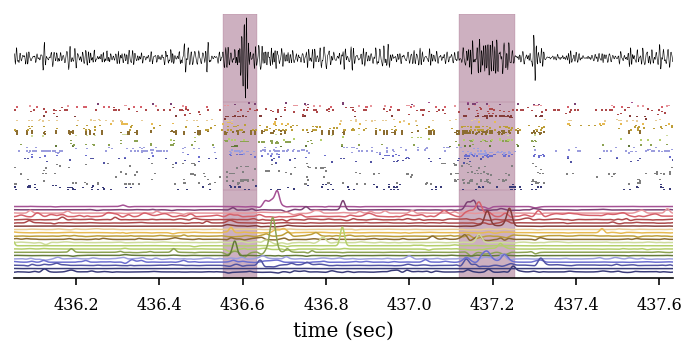

In [385]:


# for event in swr_df[swr_df.session == session].itertuples():
temp_df = swr_df[swr_df.session == session]
event = temp_df[temp_df.ripple_number == 63].iloc[0]

temp_df = swr_df[swr_df.session == session]
interval = [event.start_time-.5, event.end_time+1]

fig, axs = plt.subplots(3,1, figsize=functions.set_size('thesis', fraction=1, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0)
axs = axs.ravel()  
plot_assembl_strength(st,patterns,assembly_act,interval,axs,show_not_in_assmbl=False,vertstack=True)

idx = (lfp_ts >= interval[0]) & (lfp_ts <= interval[1])
axs[0].plot(lfp_ts[idx],lfp[idx,event.peak_channel],color='k',linewidth=.3,alpha=1)
axs[0].set_xlim(interval[0],interval[1])
axs[0].axis('off')

for item in temp_df[temp_df['peak_time'].between(interval[0], interval[1])].itertuples():
    axs[0].axvspan(item.start_time, item.end_time, alpha=0.4, color='#843b62', zorder=-2000)
    axs[1].axvspan(item.start_time, item.end_time, alpha=0.4, color='#843b62', zorder=-2000)
    axs[2].axvspan(item.start_time, item.end_time, alpha=0.4, color='#843b62', zorder=-2000)

# axs[1].axes.get_yaxis().set_ticks([])
# axs[1].axes.get_yaxis().set_visible(False)
axs[2].spines["left"].set_visible(False)
axs[2].axes.get_yaxis().set_visible(False)
axs[2].set_ylim(-20,250)
axs[2].set_xlabel('time (sec)')

axs[1].set_ylabel('n units')
axs[2].set_ylabel('n assemblies')

plt.savefig(os.path.join(fig_save_path,'assembly_examples_'+session,str(event.ripple_number)+'_assembl_example.svg'),dpi=300,bbox_inches='tight')
# break

In [386]:
event

Unnamed: 0                            5228
ripple_number                           63
start_time                         436.552
end_time                          436.6336
ripple_duration                     0.0816
max_emg                           0.746491
peak_time                         436.6064
peak_channel                             1
peak_amplitude                    7.434093
peak_freq                       189.302322
clipped                           0.006667
session            LEM3206_S20190718143924
area                                   ca3
ep_type                              track
group                                  pae
rat                                LEM3206
Name: 4915, dtype: object

In [359]:
os.path.join(fig_save_path,'assembly_examples_'+session,str(event.ripple_number)+'_assembl_example.png')
# plt.figure(figsize=(20,4))
# plt.plot(lfp[(lfp_ts >= current_ripple.start_time.iloc[0]-2) & (lfp_ts <= current_ripple.end_time.iloc[0]+2),current_ripple.peak_channel])


'D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/replay_section/assembly_examples_LEM3206_S20190718143924\\90_assembl_example.png'

# Testing below

In [317]:
import h5py
def add_epoch_type(df,data_path):
    dicts = {}
    for session in df.session:
        f = h5py.File(data_path+session+'.mat','r')
        ex_ep = []
        for i in range(f['events'].shape[0]):
            ex_ep.append(f['events'][i])
        dicts[session] = ex_ep

    ep_type = ['pedestal_1','track','pedestal_2','cylinder_1','pedestal_3','cylinder_2','pedestal_4']
    df['ep_type'] = np.ones_like(df.session)
    # session_df=pd.DataFrame()
    for session in np.unique(df.session):
        # stack epoch times
        b = np.hstack(dicts[session])

        # add 0 to start to indicate the start of the recording session
        b = np.insert(b,0,0)

        # add the ts of the last ripple of the session to indicate end of session
        b = list(b)
        last_rip = max(df.ts[df.session == session])
        if b[-1] < last_rip:
            b.append(last_rip)

        # loop through each epoch and label each ripple
        for ep in range(len(b)-1):
            idx = (df.session == session) & (df.ts >= b[ep]) & (df.ts <= b[ep+1])
            df.loc[idx,'ep_type'] = ep_type[ep]

    return df

data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
# df = add_epoch_type(df,data_path)

In [304]:
spikes = np.load(os.path.join(spike_path,session)+'.npy', allow_pickle=True)
spikes_ = list(itertools.chain(*spikes))
session_bounds = nel.EpochArray([min(spikes_), max(spikes_)])

In [323]:
ts = np.arange(min(spikes_), max(spikes_),.5)

df_test = pd.DataFrame()
df_test['session'] = np.full(ts.shape[0], session)
df_test['ts'] = ts

df_test = add_epoch_type(df_test,data_path)
df_test

,session,ts,ep_type
0,LEM3116_S20180717110938,0.014684,pedestal_1
1,LEM3116_S20180717110938,0.514684,pedestal_1
2,LEM3116_S20180717110938,1.014684,pedestal_1
3,LEM3116_S20180717110938,1.514684,pedestal_1
4,LEM3116_S20180717110938,2.014684,pedestal_1
...,...,...,...
10457,LEM3116_S20180717110938,5228.514684,pedestal_4
10458,LEM3116_S20180717110938,5229.014684,pedestal_4
10459,LEM3116_S20180717110938,5229.514684,pedestal_4
10460,LEM3116_S20180717110938,5230.014684,pedestal_4


In [330]:
ep_types = []
epoch_durations = []
sessions = []
for session in pd.unique(swr_df.session):
    # load spikes to get max and min of session
    spikes = np.load(os.path.join(spike_path,session)+'.npy', allow_pickle=True)
    spikes_ = list(itertools.chain(*spikes))
    # generate time stamps with dt of .5 seconds
    ts = np.arange(min(spikes_), max(spikes_),.5)
    # make df to feed into add_epoch_type
    df_test = pd.DataFrame()
    df_test['session'] = np.full(ts.shape[0], session)
    df_test['ts'] = ts
    df_test = add_epoch_type(df_test,data_path)
    # loop through each ep_type to collect ep type and epoch durations
    for ep_type in pd.unique(df_test.ep_type):
        sessions.append(session)
        ep_types.append(ep_type)
        epoch_durations.append(df_test.ts[df_test.ep_type == ep_type].max() - df_test.ts[df_test.ep_type == ep_type].min())


In [337]:
epoch_df = pd.DataFrame()

epoch_df['session'] = sessions
epoch_df['ep_type'] = ep_types
epoch_df['epoch_duration'] = epoch_durations

epoch_df = add_group_affiliation(epoch_df)

rat = [s.split('_')[0] for s in epoch_df.session]
epoch_df['rat']=rat

epoch_df

epoch_df.to_csv('F:/Projects/PAE_PlaceCell/analysis/epoch_df.csv')


<ipython-input-6-05ca260294d6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-6-05ca260294d6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


pedestal_1 59.07754010695187
track 694.521164021164
pedestal_2 216.48022598870057
cylinder_1 935.2314814814815
pedestal_3 192.5895061728395
cylinder_2 1076.56875
pedestal_4 48.56875


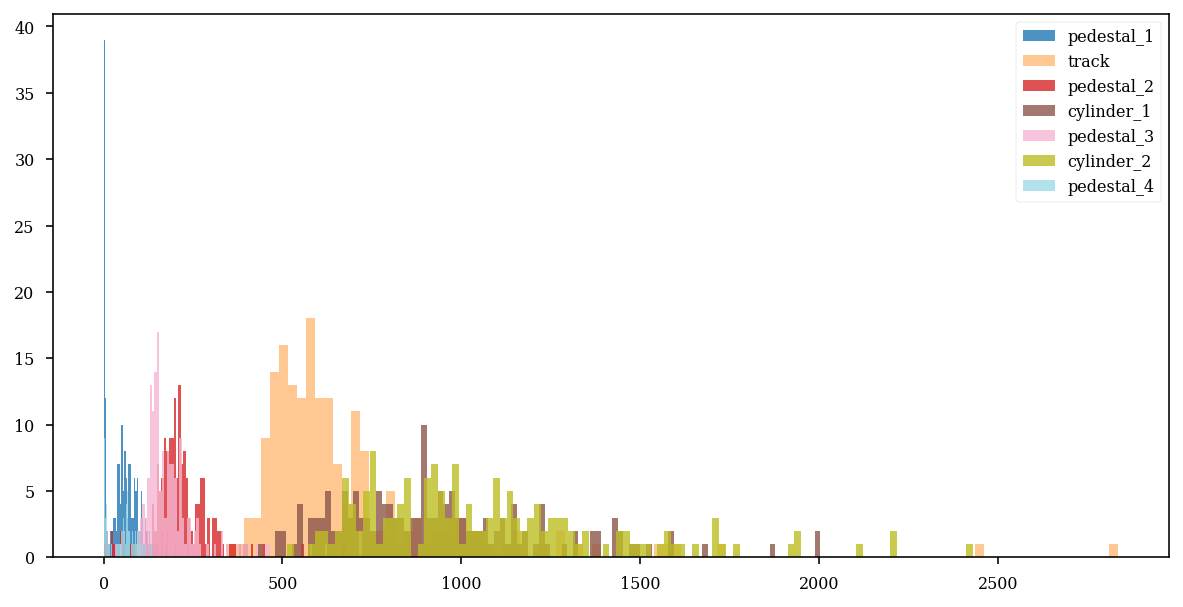

In [390]:
cmap = matplotlib.cm.get_cmap('tab20',len(pd.unique(epoch_df.ep_type)))
plt.figure(figsize=(10,5))
for i,ep_type in enumerate(pd.unique(epoch_df.ep_type)):
    print(ep_type,epoch_df.epoch_duration[epoch_df.ep_type == ep_type].mean())
    plt.hist(epoch_df.epoch_duration[epoch_df.ep_type == ep_type],100,alpha=.8,color=cmap(i),label=ep_type)
plt.legend()

In [368]:

def add_group_affiliation_(df):
    control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
    pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

    df['group'] = np.ones_like(df.session)

    regstr = '|'.join(control)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.group[idx] = 'control'

    regstr = '|'.join(pae)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.group[idx] = 'pae'
    return df

temp_df = cell_list[(cell_list.area == 'ca1') | (cell_list.area == 'ca3')]
session_df = pd.DataFrame()
session_df['session'] = pd.unique(temp_df.session)
session_df = add_group_affiliation_(session_df)


session_df.to_csv('F:/Projects/PAE_PlaceCell/analysis/session_df.csv')
